<a href="https://colab.research.google.com/github/WambuiN/Loan_Predictor/blob/main/Copy_of_Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color=”green”> Importing libraries </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## <font color=”green”> Loading dataset </font>

In [58]:
loans = pd.read_csv('train_dataset.csv')
# test = pd.read_csv('test_dataset.csv')

## <font color=”green”>Exploring our Dataset  </font>

In [3]:
loans.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [4]:
loans.tail()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3
164308,10164309,"9,250",10+ years,Rent,NaN,VERIFIED - income,credit_card,19.44,1,NaN,5,9,Female,2


In [5]:
loans.shape

(164309, 14)

In [6]:
loans.duplicated().sum()

0

> no duplicate values

In [7]:
loans.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

> There is a lot of null values in the dataset but cannot be dropped.

* Length employed <- Some borrowers may have not been previously employed, thats why there are null values
* Home owner <- Others can be living with family and friends.
* Annual Income <- Some borrowers may have not been previously employed or some may not have a ligitimate source of income or 😅 they are politicians ... etc
* Months since deliquency <-  In a financial sense, delinquency occurs as soon as a borrower misses a payment on a loan. In contrast, default occurs when a borrower fails to repay the loan as specified in the original contract

In [8]:
loans.dtypes

Loan_ID                      int64
Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

> Our datatypes is comprised of both intergers and strings

#### <font color=”green”>Cleaning our Dataset  </font>

**Loan amount requested**

In [9]:
loans['Loan_Amount_Requested'] = loans['Loan_Amount_Requested'].str.replace(',', '')
loans['Loan_Amount_Requested'] = loans['Loan_Amount_Requested'].astype('int')

> Loan_Amount_Requested had commas and had to be replaced

**Lenght employed**

In [10]:
le = loans['Length_Employed']

In [11]:
le.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

In [12]:
le[le=='< 1 year'] = '0 years'
le.fillna('0 years', inplace=True)

> We combined those who did not give their time employed and those who had 0 to 1 year of employment time

In [14]:
lef = le.str.replace('years','').str.replace('year','').str.replace('<','').str.replace('+','').str.replace(' ','')

> We then removed the strings in the column leaving only the integers

In [15]:
loans['Length_Employed']=lef.astype('int')

**Home owner**

In [16]:
own = loans['Home_Owner']
own.value_counts()

Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [17]:
loans['Home_Owner']=own.fillna('Other')

**Annual_Income**

In [18]:
loans['Annual_Income'].mean()

73331.15943386468

In [19]:
import tqdm
def fix(dfr):
  na=dfr['Annual_Income'][dfr['Annual_Income'].isna()==True].index
  # df=pd.concat([train,test])
  for ind in tqdm.tqdm(na):
    # ind=dfr['Age'].index
    purpose     =dfr['Purpose_Of_Loan'].iloc[ind]
    gender      =dfr['Gender'].iloc[ind]
    debt_income =dfr['Debt_To_Income'].iloc[ind]
    mn=(dfr['Annual_Income'][(dfr['Purpose_Of_Loan']==purpose) & 
                             (dfr['Gender']==gender) &
                             ((dfr['Debt_To_Income'] <= (debt_income+1))& 
                              (dfr['Debt_To_Income'] >= (debt_income-1))
                              )]).mean()
    # print(mn)
    dfr['Annual_Income'].iloc[ind]= mn
    pass
fix(loans)


100%|██████████| 25102/25102 [14:23<00:00, 29.08it/s]


> We imputed the null values with customers with the average income from 

1.   List item
2.   List item

customers with a similar purpose of loan and within -1,+1 of the customers debt to income.

**Deliquency**

In [20]:
loans['Months_Since_Deliquency'].isna().sum()

88379

In [21]:
# Creating the classifications of the customers from 
def status(x):
  if x<=3.0:
    return 'Normal'
  elif ((x>3.0) & (x<=12.0)):
    return 'Medium risk'
  elif x>12.0:
    return 'High risk'
  else:
    return 'Low risk'

In [22]:
loans['deliquency_level']=loans.apply(lambda x: status(x['Months_Since_Deliquency']),axis=1)

In [23]:
loans.drop('Months_Since_Deliquency',axis=1,inplace=True)
loans['deliquency_level'].value_counts()

Low risk       88379
High risk      61548
Medium risk    12210
Normal          2172
Name: deliquency_level, dtype: int64

In [24]:
loans.dropna(inplace=True)

In [25]:
loans.isna().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
Interest_Rate            0
deliquency_level         0
dtype: int64

#### Checking for Outliers

In [26]:
sns.set(rc={'figure.figsize':(18,6)},style="white")

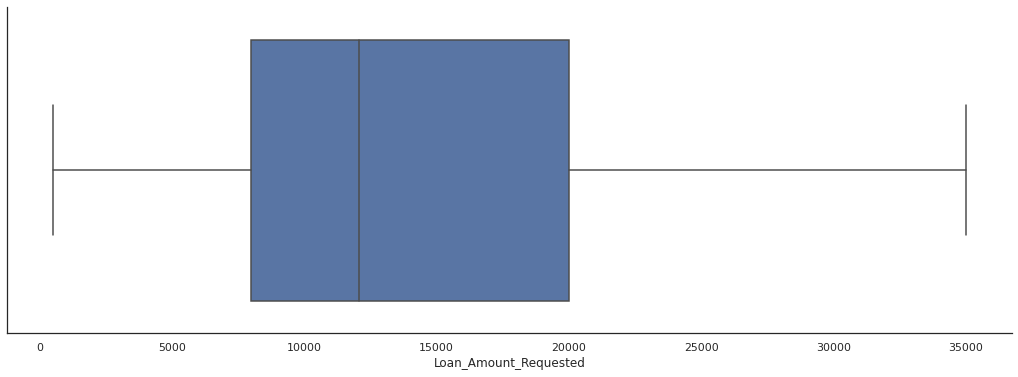

In [27]:
sns.boxplot(x=loans['Loan_Amount_Requested'])
sns.despine()

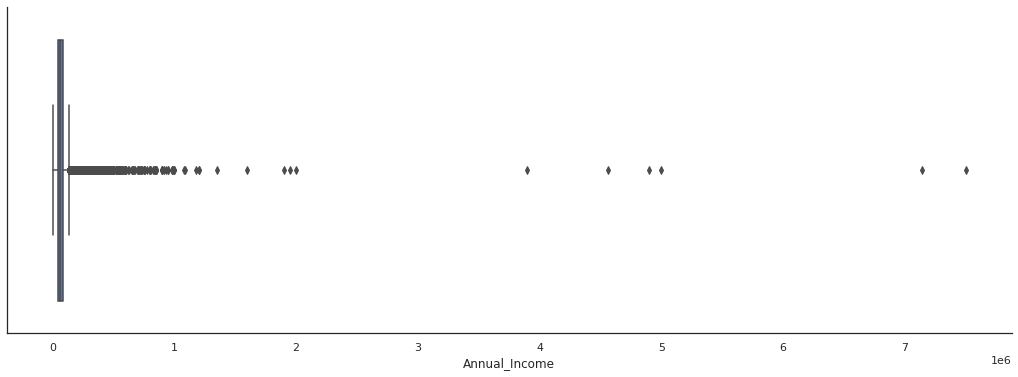

In [ ]:
sns.boxplot(x=loans['Annual_Income'])
sns.despine()

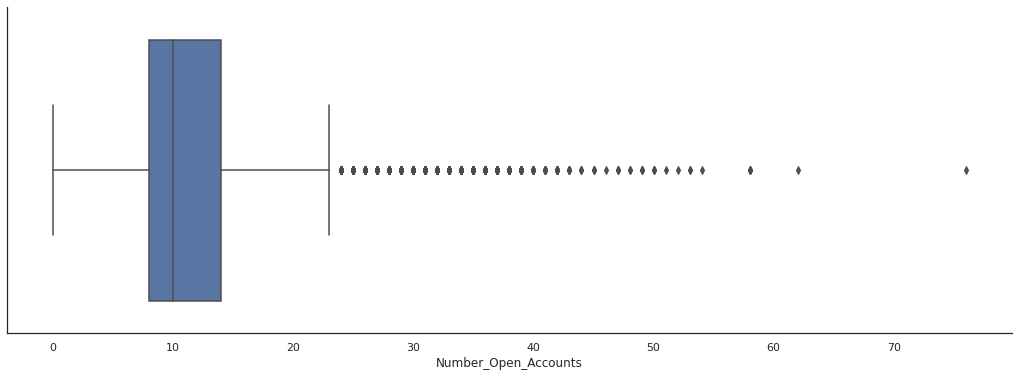

In [ ]:
sns.boxplot(x=loans['Number_Open_Accounts'])
sns.despine()

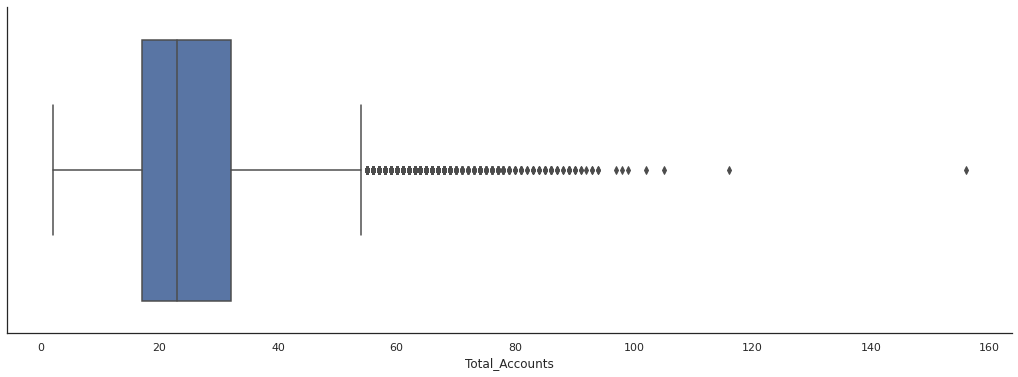

In [ ]:
sns.boxplot(x=loans['Total_Accounts'])
sns.despine()

> In our interger columns we have outliers in all columns apart from loan amount requested

### <font color=”green”>Exploratory Analysis </font>

##### <font color="yellow">Univariate Analysis  </font>

In [28]:
loans.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,deliquency_level
0,10000001,7000,0,Rent,68000.000000,not verified,car,18.37,0,9,14,Female,1,Low risk
1,10000002,30000,4,Mortgage,76646.058884,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female,3,High risk
2,10000003,24725,7,Mortgage,75566.400000,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male,3,Low risk
3,10000004,16000,0,Other,56160.000000,VERIFIED - income source,debt_consolidation,14.34,3,16,22,Male,3,Low risk
4,10000005,17000,8,Own,96000.000000,VERIFIED - income source,debt_consolidation,22.17,1,19,30,Female,1,Low risk


In [ ]:
# Frequency distribution table for purpose of loan attribute
loans['Purpose_Of_Loan'].value_counts()

debt_consolidation    97101
credit_card           36684
home_improvement       9268
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation                834
wedding                 828
house                   773
renewable_energy        122
educational             121
Name: Purpose_Of_Loan, dtype: int64

> From the value counts the loans were purposely for debt consolidation.

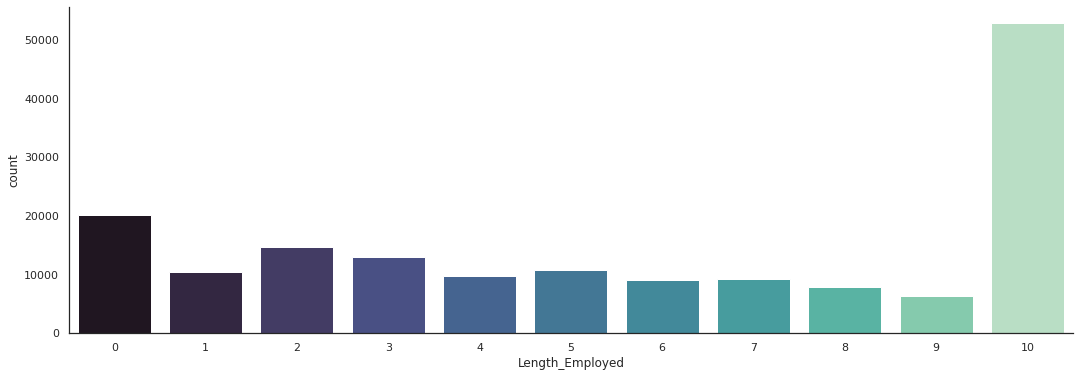

In [ ]:
sns.countplot(x='Length_Employed',data=loans,palette='mako')
sns.despine()

* 10+ years were the highest to request for a loan

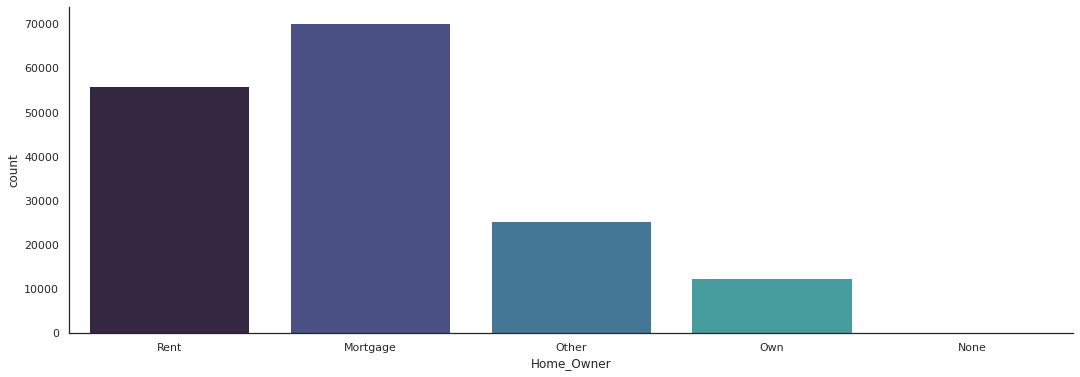

In [ ]:
# Plotting bar chart to show home ownership
sns.countplot(x='Home_Owner',data=loans,palette='mako')
sns.despine()

* The Mortgage home owners are the highest and owned home_owners lowest

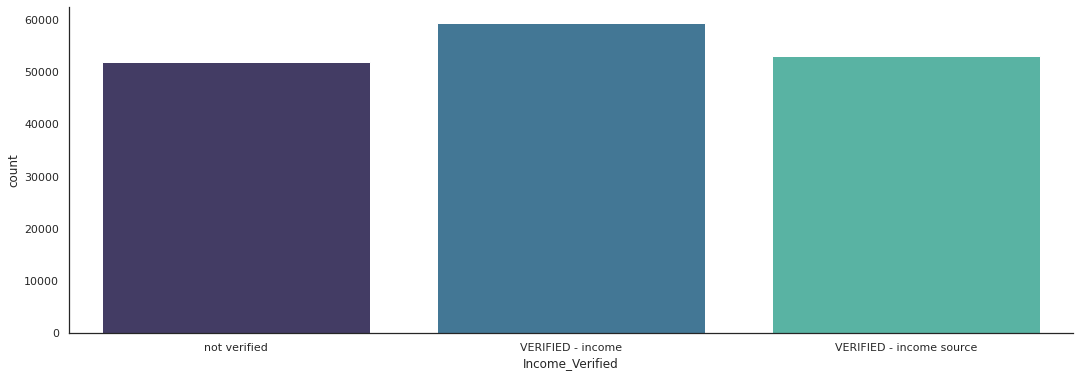

In [ ]:
# Plotting bar chart to show income verified 
sns.countplot(x='Income_Verified',data=loans,palette='mako')
sns.despine()

 On verified income individuals the ones who have Verified income have the highest count and not verified lowest count.

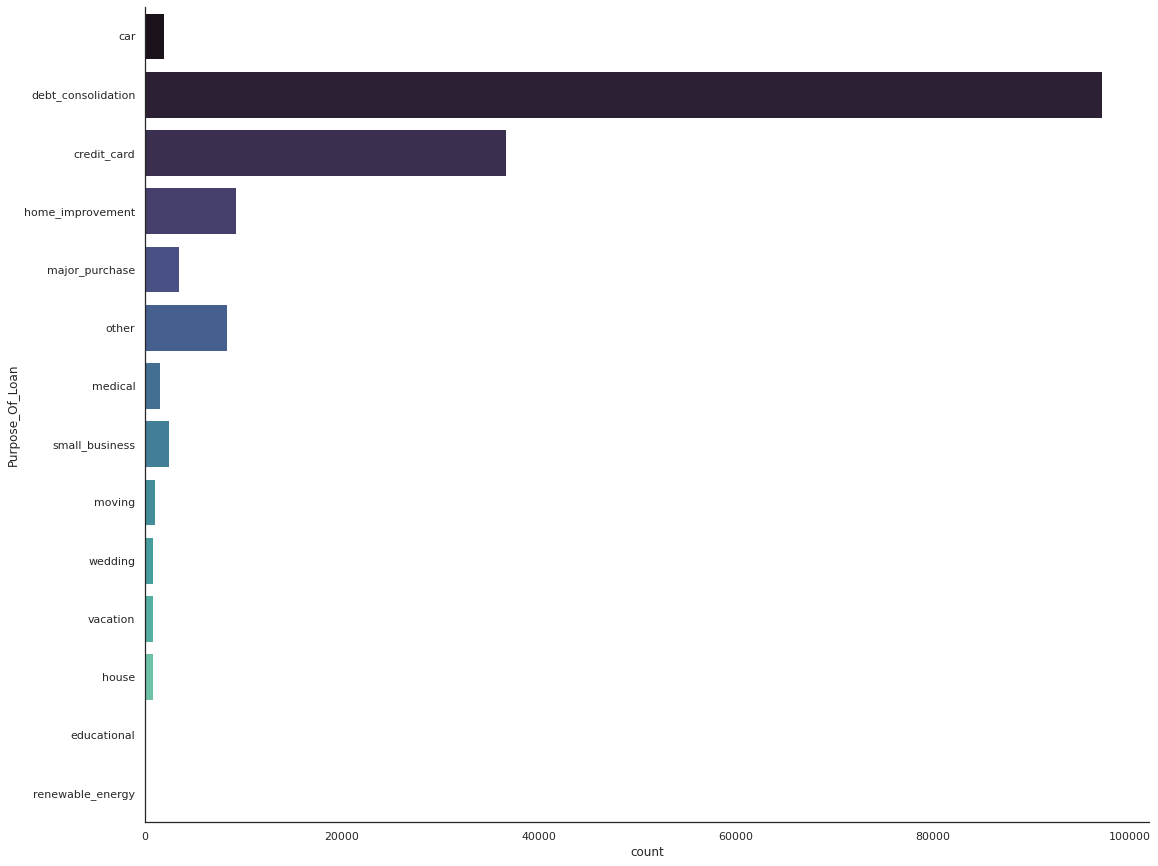

In [ ]:
# Plotting bar chart to show purpose of loan 
sns.countplot(y='Purpose_Of_Loan',data=loans,palette='mako')
sns.despine()

Debt_consolidatiion had the highest count refering that loans taken were purposely for debt consolidation.

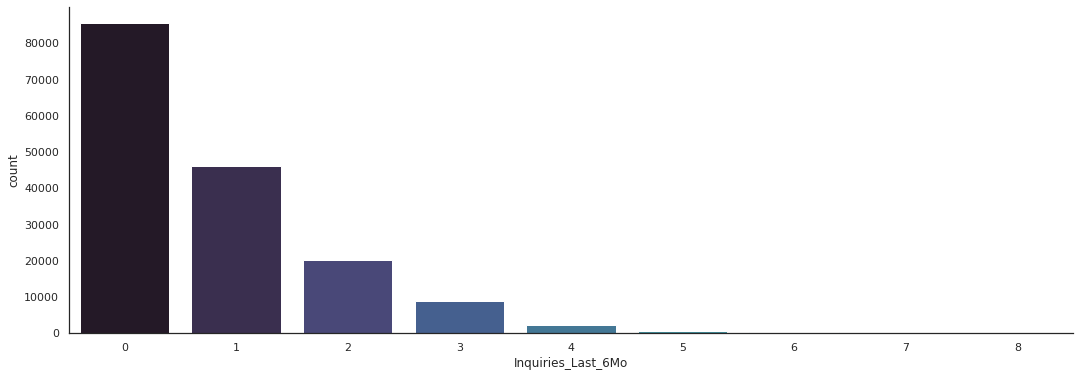

In [ ]:
# Plotting bar chart to show inquiries in last 6 months. 
sns.countplot(x='Inquiries_Last_6Mo',data=loans,palette='mako')
sns.despine()

Most of the enquiries are done during the initial months, decreasing towards the sixth month.

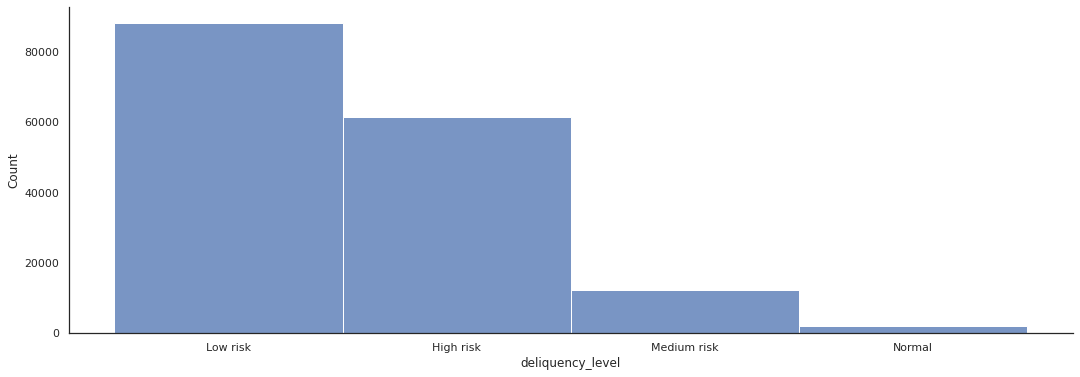

In [ ]:
sns.histplot(x='deliquency_level',data=loans,palette='mako')
sns.despine()

> **description deliquency**<- In a financial sense, delinquency occurs as soon as a borrower misses a payment on a loan. In contrast, default occurs when a borrower fails to repay the loan as specified in the original contractMost are low risk clients are highest and normal client who do not default are lowest

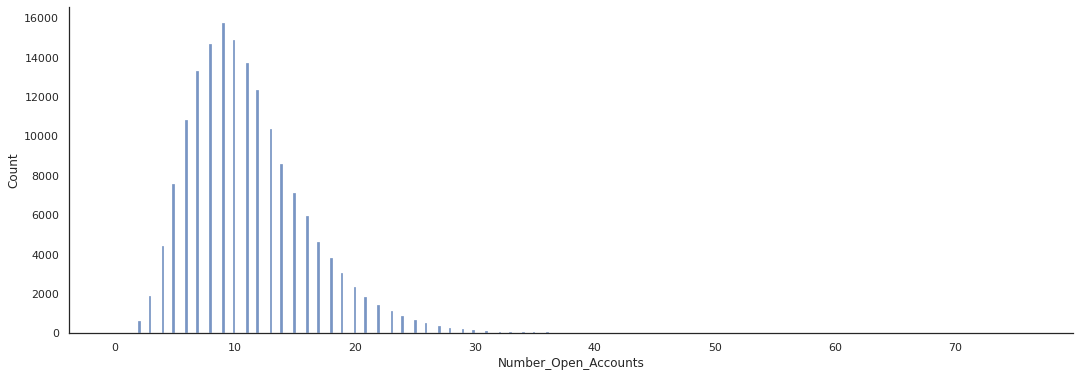

In [ ]:
sns.histplot(x='Number_Open_Accounts',data=loans,palette='mako')
sns.despine()

> Most clients have more than one accounts opened as we can see above its right-skewed.With most having more than 10.

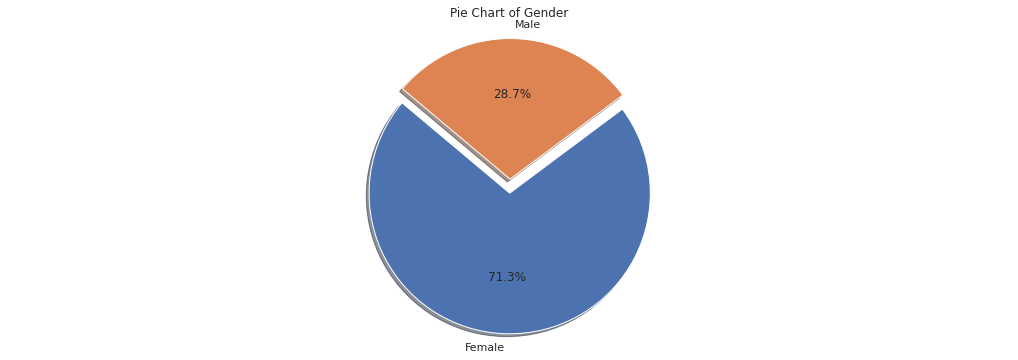

In [ ]:
#Gender Distribution
Gender = loans['Gender'].value_counts()
labels = loans.Gender.unique()
explode = (0.1, 0) 
plt.pie(Gender, labels = labels, explode = explode,autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.title('Pie Chart of Gender')
plt.show()

> Males have the highest percentage in loan applications with a 71 percent higher than females with percentage of 29 percent.

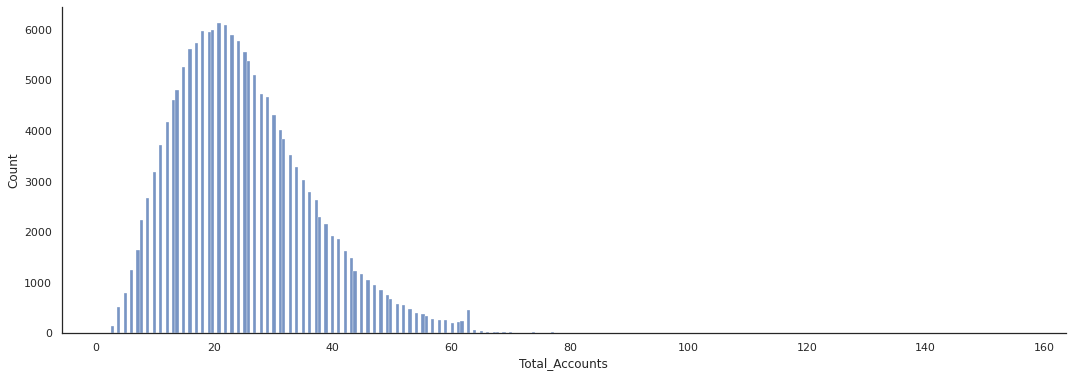

In [ ]:
# Plotting histogram for Total Accounts 
sns.histplot(loans['Total_Accounts'])
sns.despine()

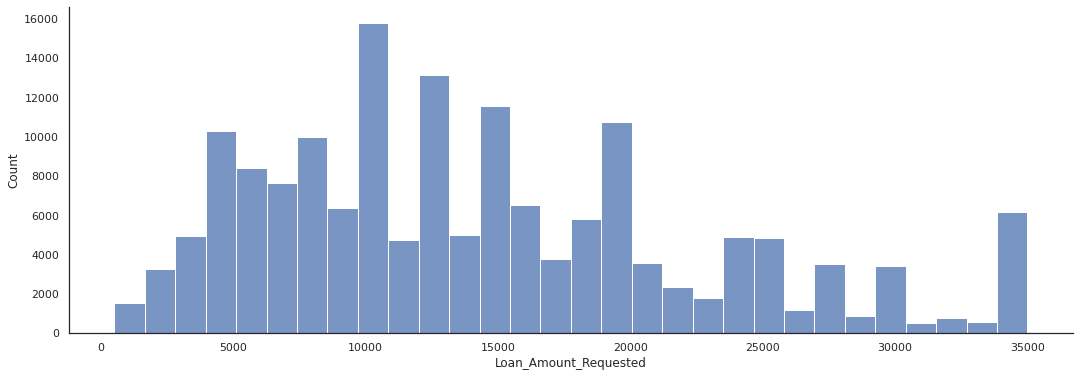

In [ ]:
# Plotting bar chart to show Loan amount requested
sns.histplot(x='Loan_Amount_Requested',data=loans,palette='mako',bins=30)
sns.despine()

The most loan Amount value requested is 10000

##### <font color="yellow">Measures of central Tendecy  </font>

In [ ]:
# mean, mode and median Annual income

print('Mean Annual income is ' + str(loans.Annual_Income.mean()))
print('Median Annual income is ' + str(loans.Annual_Income.median()))
print('Mode Annual income is ' + str(loans.Annual_Income.mode()))

Mean Annual income is 73323.94196885795
Median Annual income is 65139.29977890835
Mode Annual income is 0    60000.0
dtype: float64


In [ ]:
# mean, mode and median Total accounts

print('Mean  Total accounts is ' + str(loans.Total_Accounts.mean()))
print('Median Total accounts is ' + str(loans.Total_Accounts.median()))
print('Mode  Total accounts is ' + str(loans.Total_Accounts.mode()))

Mean  Total accounts is 25.067606388158534
Median Total accounts is 23.0
Mode  Total accounts is 0    21
dtype: int64


In [ ]:
#checking for measures of central tendency of relevant columns
loans_ = loans[['Loan_Amount_Requested','Annual_Income','Inquiries_Last_6Mo','Number_Open_Accounts', 'Total_Accounts']]
loans_.describe()

,Loan_Amount_Requested,Annual_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts
count,164304.000000,1.643040e+05,164304.000000,164304.000000,164304.000000
mean,14349.430933,7.332394e+04,0.781716,11.193824,25.067606
std,8281.699126,5.579038e+04,1.034755,4.991867,11.583167
min,500.000000,4.000000e+03,0.000000,0.000000,2.000000
25%,8000.000000,4.850000e+04,0.000000,8.000000,17.000000
50%,12075.000000,6.513930e+04,0.000000,10.000000,23.000000
75%,20000.000000,8.500000e+04,1.000000,14.000000,32.000000
max,35000.000000,7.500000e+06,8.000000,76.000000,156.000000


### <font color=”green”>Bivariate Analysis</font>>
<font color="yellow">Comparison Graphs </font>

 **Ploting the bivariate summaries and recording observations**

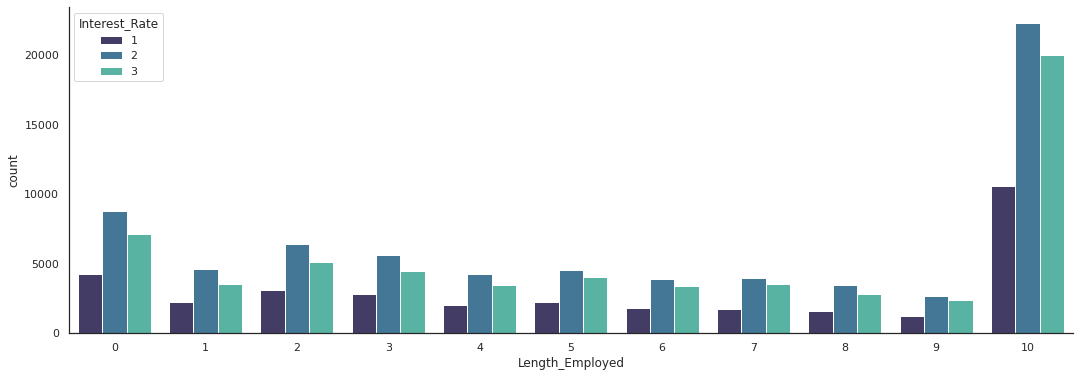

In [ ]:
sns.countplot(data=loans,x='Length_Employed',hue='Interest_Rate',palette='mako')
sns.despine()

The clients who have been employed for 10 years or longer were observed to have the medium to highest interest rate.
Also the clients employed for less than one year also had high interest rate.

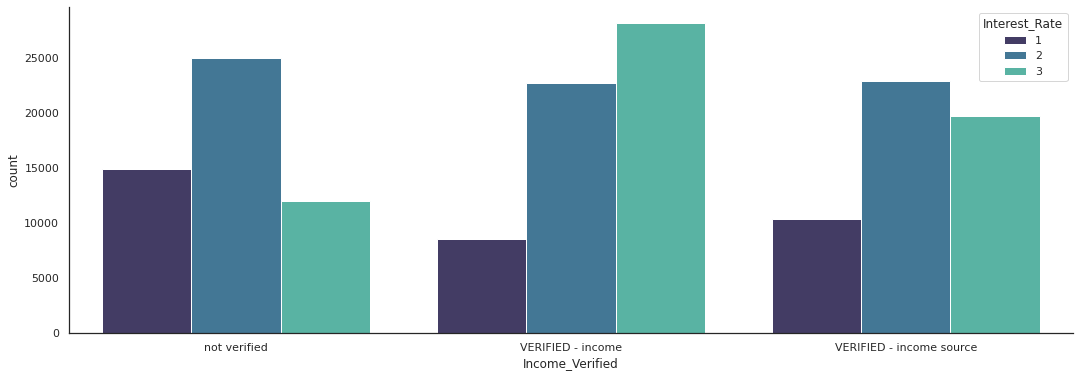

In [ ]:
sns.countplot(x='Income_Verified',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * Clients without vefified sources of income dont have a very high interest rate 
> * Clients with verified sources of high have high interest rates 
> * clients with verified income source dont have a high interest rates

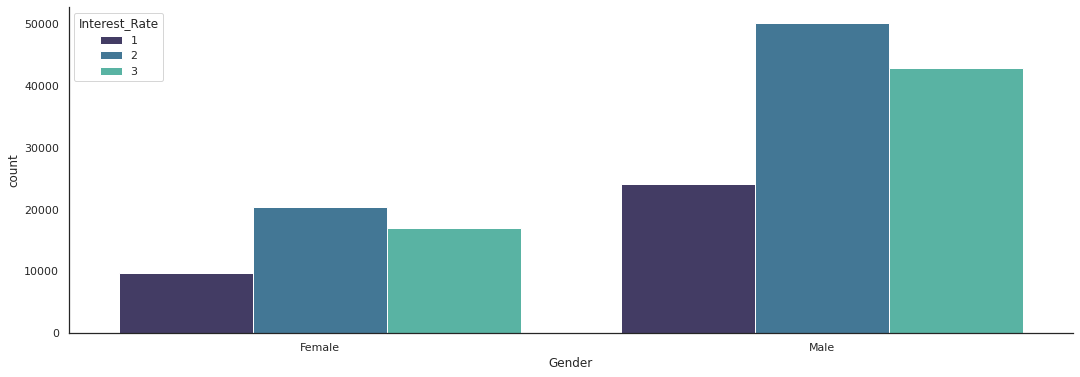

In [ ]:
sns.countplot(x='Gender',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * For all interes high,low,and medium male clients have the highest interest rates

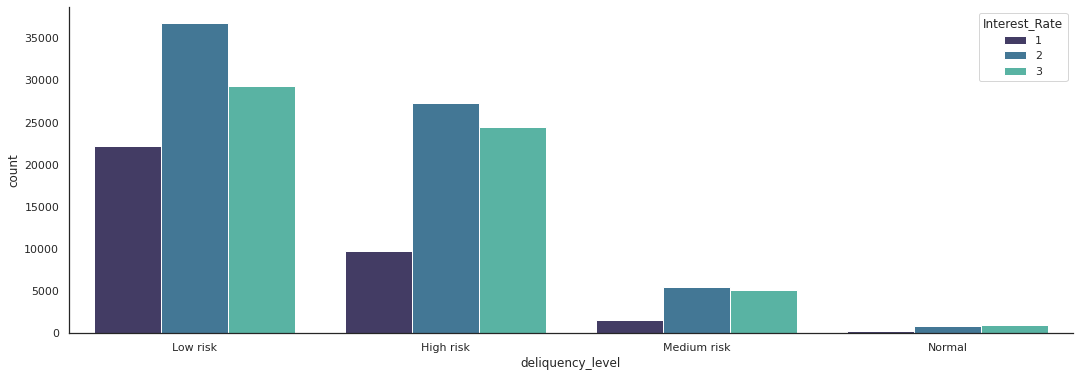

In [ ]:
sns.countplot(x='deliquency_level',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * low risk clients have the highest interest rate

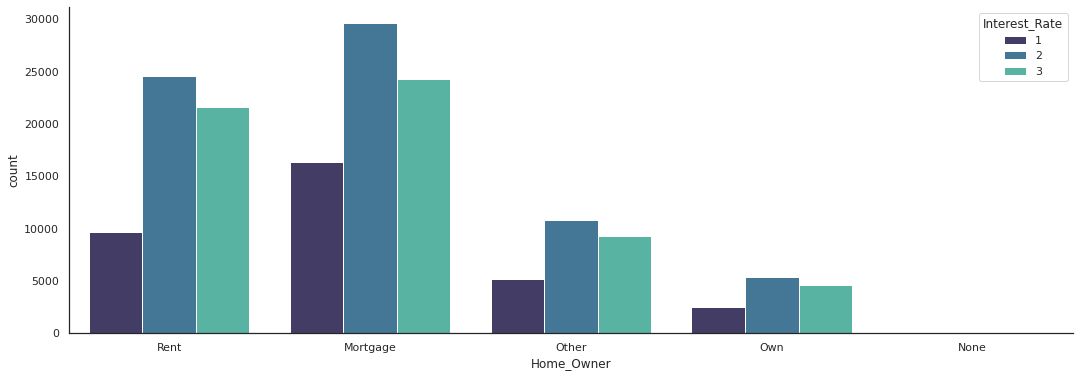

In [ ]:
sns.countplot(x='Home_Owner',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

Clients with Mortage Loans have the highest interest rate followed by those who pay rent

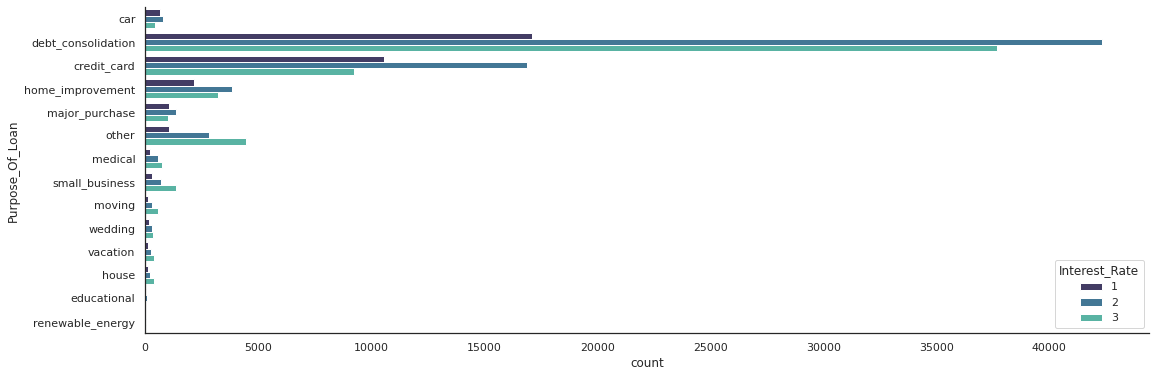

In [ ]:
sns.countplot(y='Purpose_Of_Loan',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

Most loans were given for debt consolidation and were seen to have the highest interest rate

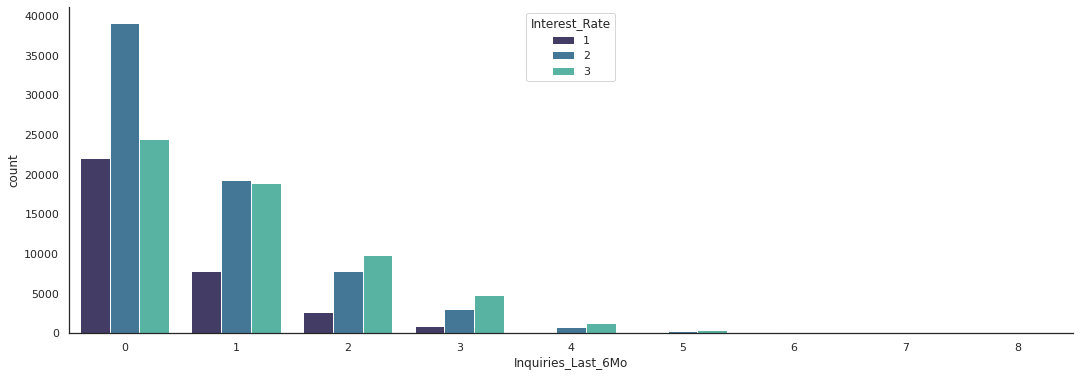

In [ ]:
sns.countplot(x='Inquiries_Last_6Mo',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

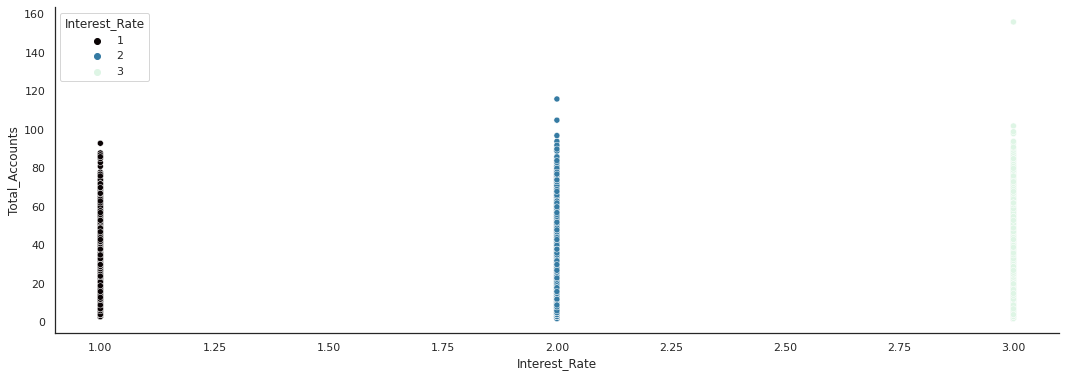

In [ ]:
sns.scatterplot(x='Interest_Rate',y='Total_Accounts',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

No relationship was observed between the total number of accounts and the interest rate.

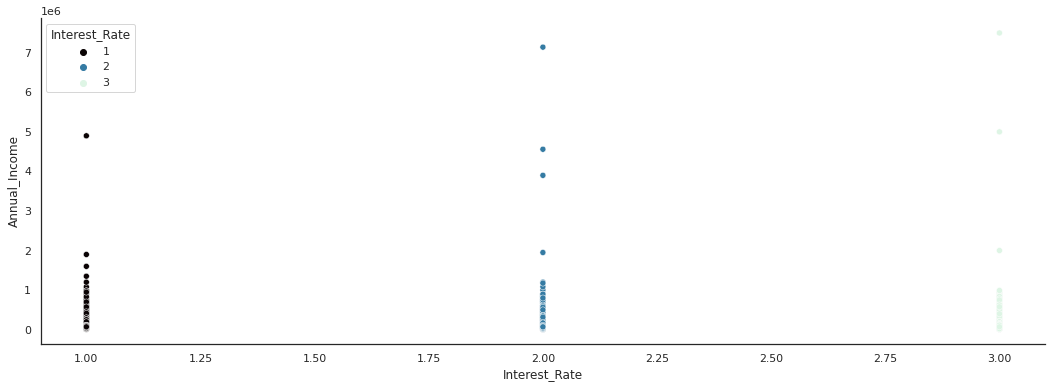

In [ ]:
sns.scatterplot(x='Interest_Rate',y='Annual_Income',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * there is no relationship between the loan interest rate and annual income

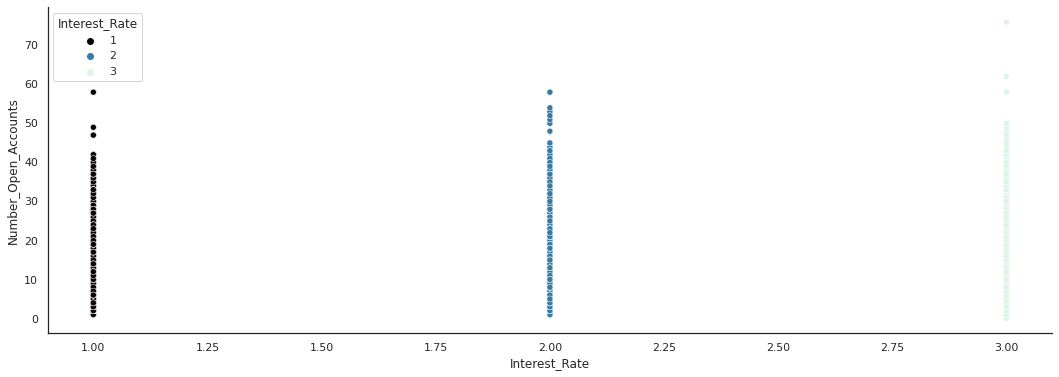

In [ ]:
sns.scatterplot(x='Interest_Rate',y='Number_Open_Accounts',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

There is no relationship observed between the number of accounts open and the interest rate.

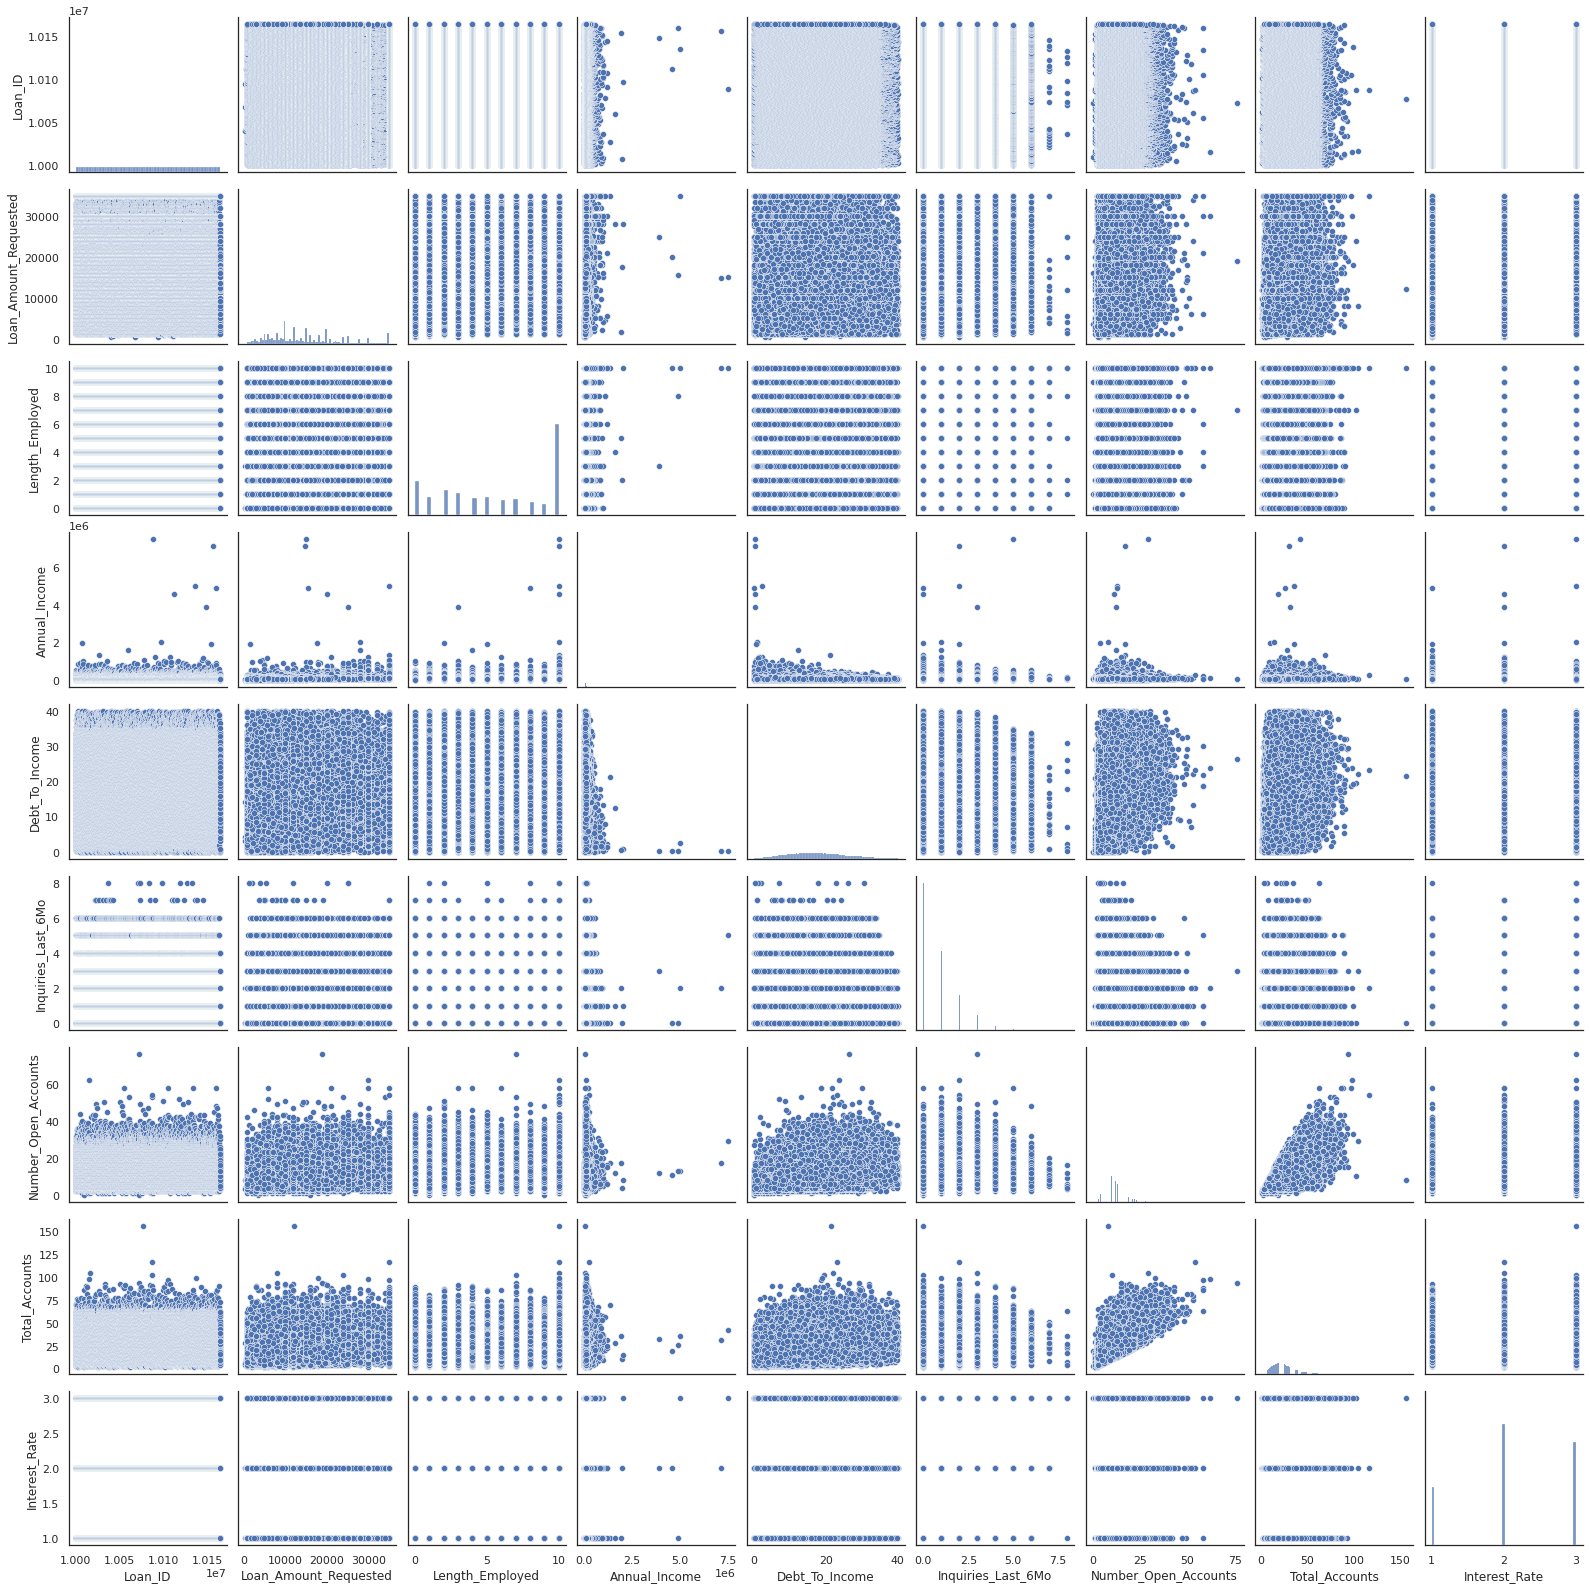

In [ ]:
# Ploting the bivariate summaries and recording observations
#
sns.pairplot(loans)
plt.show()

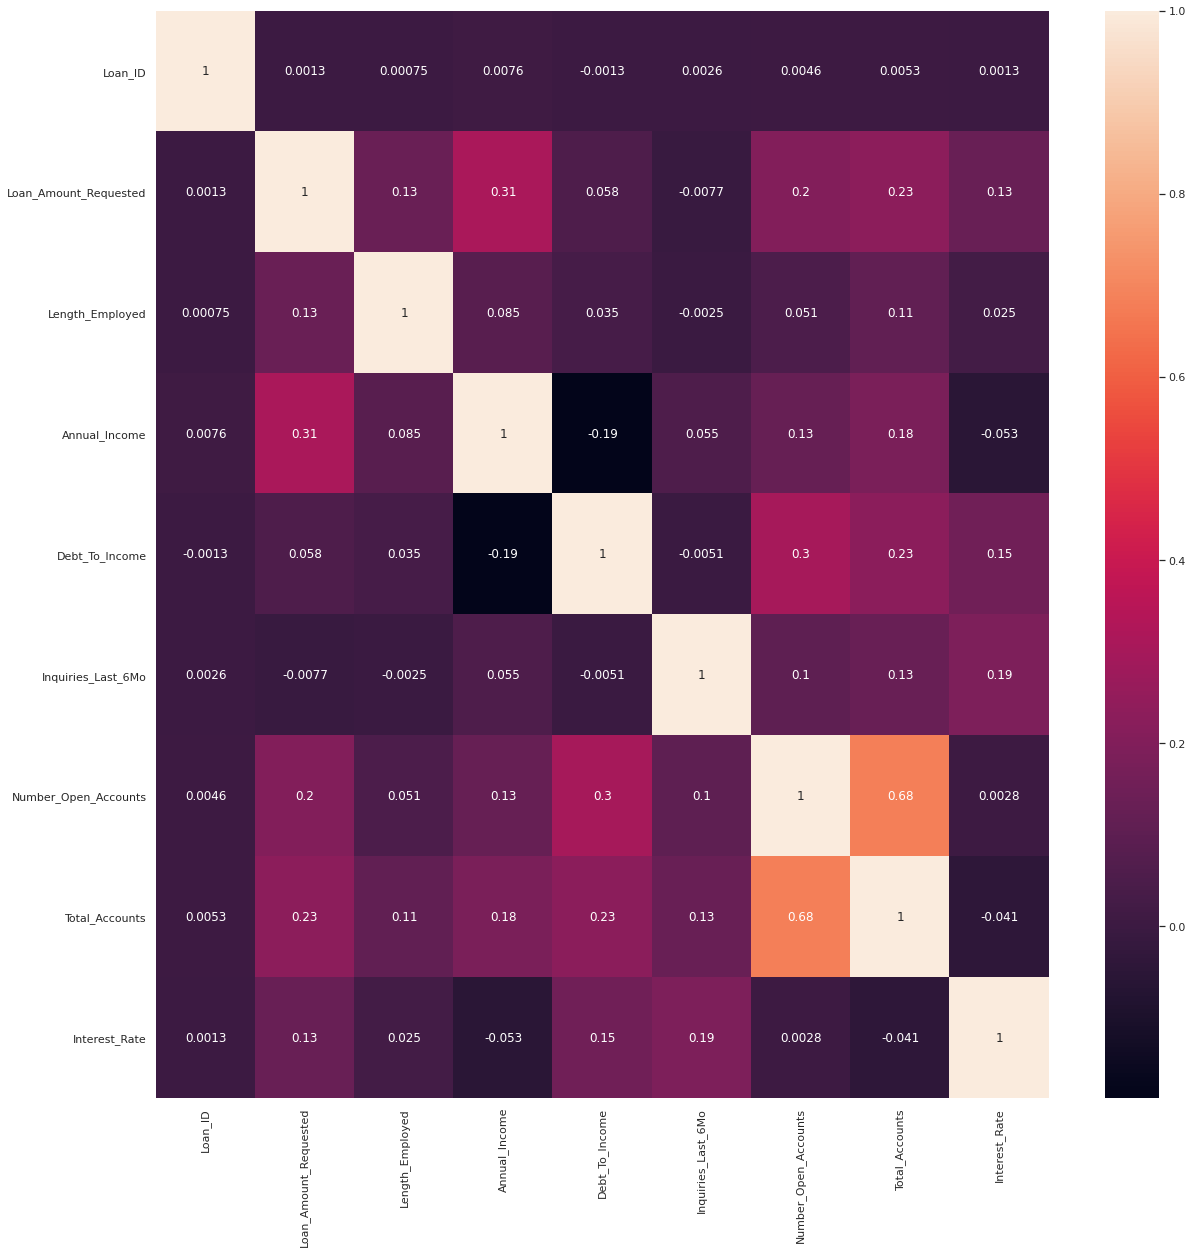

In [ ]:
# Plotting the Pearson correlation coefficient among variables
plt.figure(figsize=(20, 20))
sns.heatmap(loans.corr(),annot=True)
plt.show()

> * The columns total_accounts and number of open accounts are highly correalted with a coefficient of 0.68.

> * Interest Rate is highly correlated with 6 month Inquiries with a coefficient of 0.19

### <font color=”green”>Multivariate Analysis</font>
<background color='#fa005c--- that greenish cyan'>

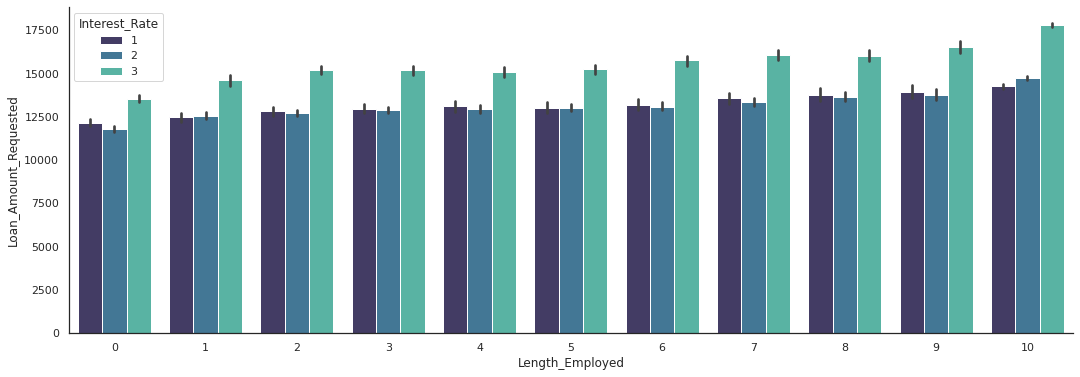

In [ ]:
sns.barplot(data=loans,x='Length_Employed',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'>Across the time customers are employed , interest rate 3 has the highest is characterised with high ammounts of loan requested, The average amount borrowed increases with time although its just a slight increase </font>
<font color='#fa005c'>
* interest rate 3 could be a high interest rate so that the bank can recover some of its money from those who pay and not get so much loss when customers default.
* However Since banks reward their long time members or offer incentives to new members the bank here could have most of its members at a lower interest rate 3 hence why its prominent irregardless of the time employed.</font>

<font color='#00e6de'>On 10+ years the least prominent category is interest rate 1 , based on the earlier assumption this could be the high end of the interest rates , since the bank would reward older members with lower interest rates (3) </font>

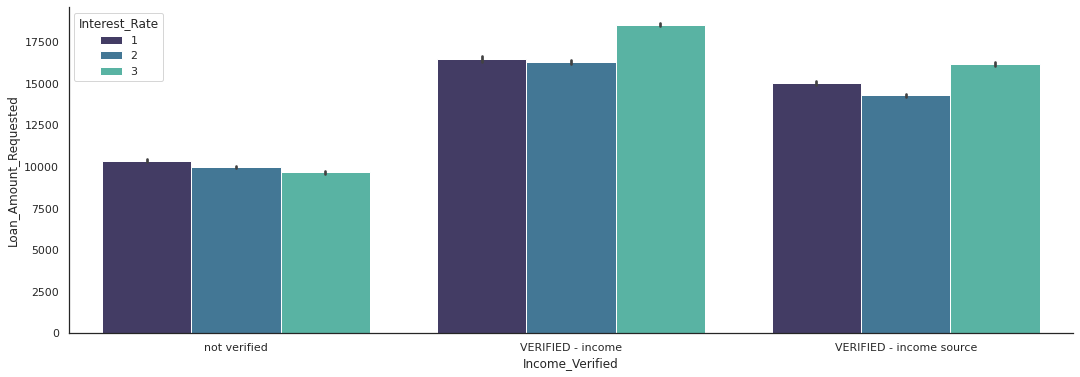

In [ ]:
sns.barplot(data=loans,x='Income_Verified',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()


><font color='#fa005c'> This further confirms the hypothesis that interest rate 1 is the highest interest rate in the dataset, since normally banks would give a high interest rate to customers whose income is not verrified to discourage them from seeking the loan and give lower interest rates to customers who have verrified incomes. </font>

><font color='#fa005c'> Those who also have no verrified income tend to seek low amounts of loans, while those with verrified incomes seek high ammounts of loans </font>

<font color='#00e6de'>This is depicted in the above plot for users whose income is verified, interest rate 3 is the highest among them.

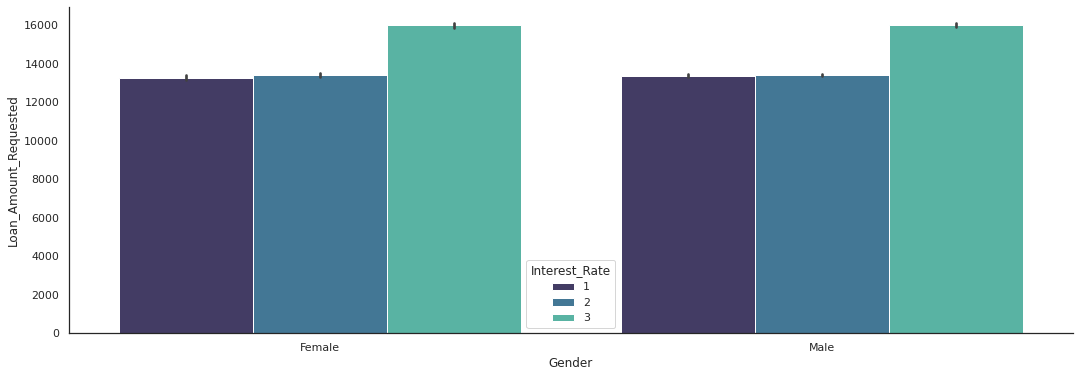

In [ ]:
sns.barplot(data=loans,x='Gender',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

><font color='#00e6de'> Gender does not have much of an impact on the interest rate or ammount borrowed since the patern from both genders does not change.

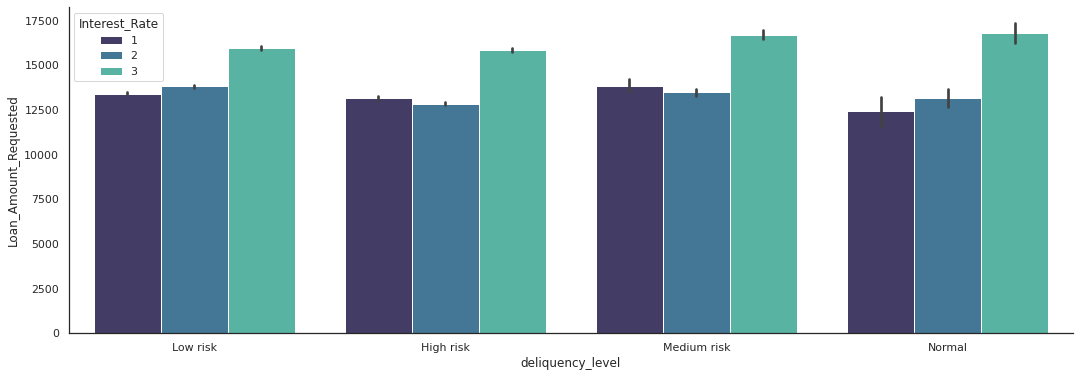

In [ ]:
sns.barplot(data=loans,x='deliquency_level',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'>Deliquency level has an effect in the pattern of the interest rates, although there is not much difference in the average ammounts borrowed across the different deliquency levels.</font>
* <font color='#fa005c'>For those with a low risk and a normal deliquency, interest rate 3 is the most prominent while interest rate 1 is the lowest, this could be the normal interest rate handed out to everyone, however this could be the lowest interest rate and since banks consider more than one factor when awarding the interest rate the high numbers with interst rate 1 could have not fulfiled some other conditions to get awarded a lower interest rate

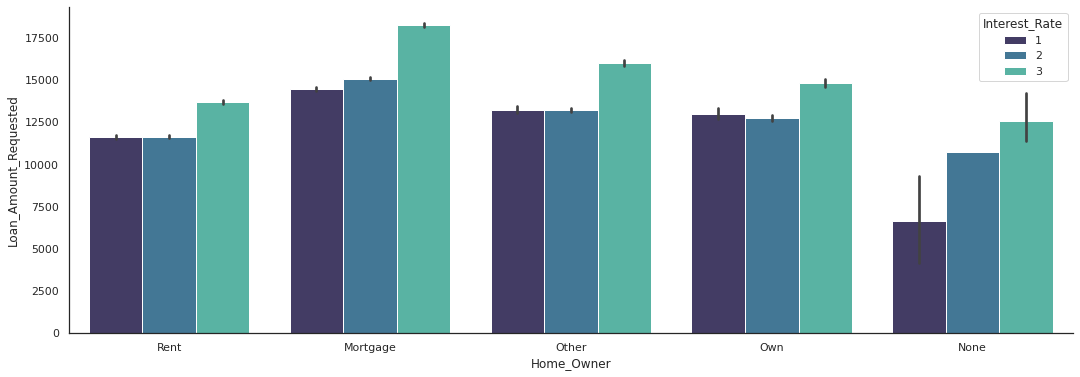

In [ ]:
sns.barplot(data=loans,x='Home_Owner',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'> As expected those who have no houses borrow the least ammounts however they all exhibit the same pattern where the interest rate with the most customers is 3 while interest rate 1 has the least customers

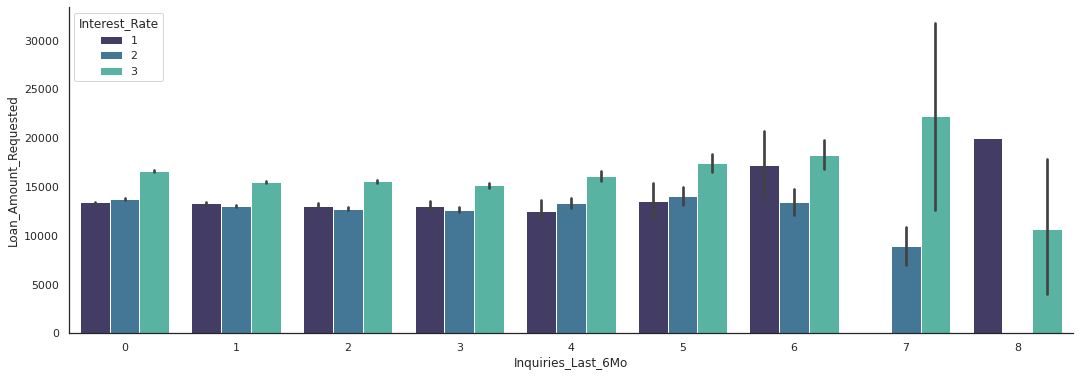

In [ ]:
sns.barplot(data=loans,x='Inquiries_Last_6Mo',y='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'> The average amount borrowed remains fairly the same for the first 5 months.

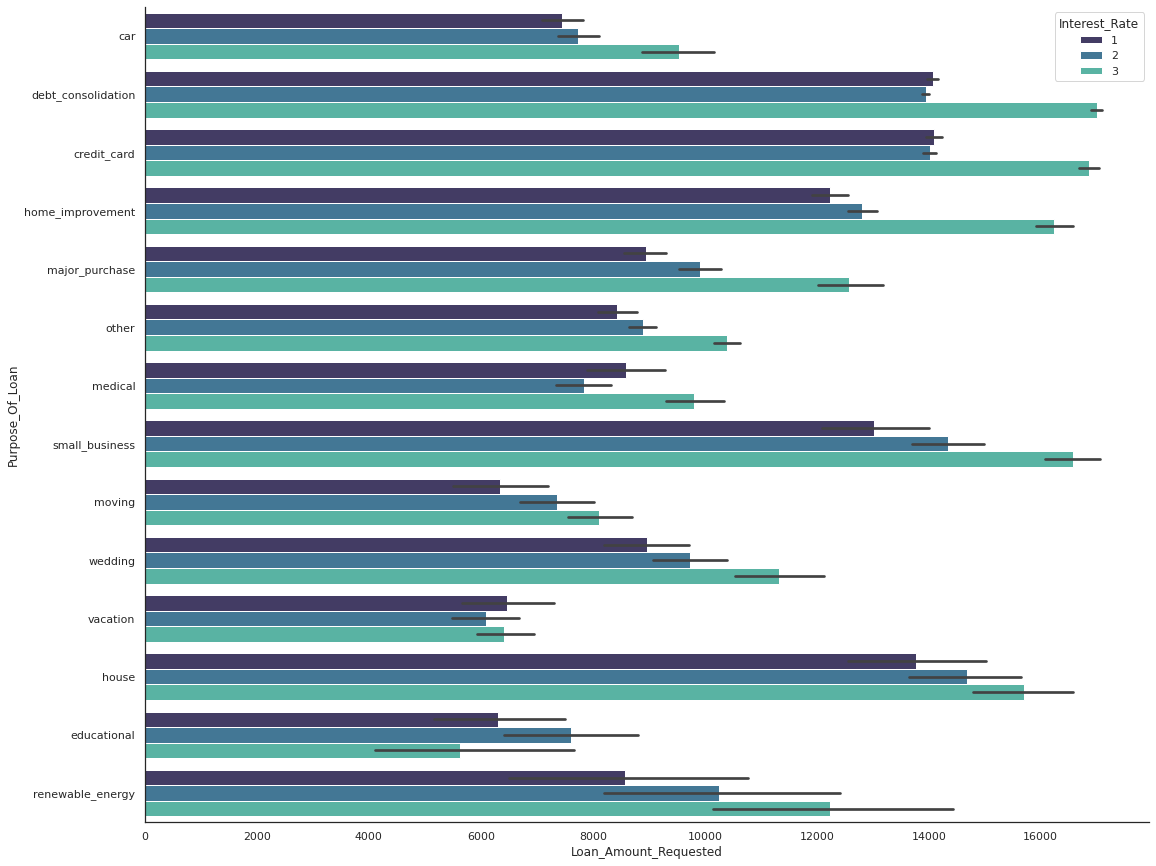

In [ ]:
sns.set(rc={'figure.figsize':(18,15)},style="white")
sns.barplot(data=loans,y='Purpose_Of_Loan',x='Loan_Amount_Requested',hue='Interest_Rate',palette='mako')
sns.despine()

<font color='#00e6de'>For most loans borrowed interest rate 3 is dominant while interest rate 1 is the least, however this changes when its a loan for vacation,medical reasons or education.
* <font color='#fa005c'> This could be because the customers probably have a decently high chance to default as is the case with alot of education loanees(<font color='#00e6de'> Helbs defaulters</font>) </font>
* <font color='#fa005c'>In medicine this could be because of an emergency and the plan to pay could not have been established before coming to get the loan, and therefore incase the loanees are start paying up the bank could have recovered a good portion if the loanee ends up defaulting.

<font color='#00e6de'> How to get the dataset for the modeling?
<font color='#fa005c'>
* Reduction using lda ?
* Reduction using feature selection ?
* Label encoding ?
* Getting dummies ?
* ..........................
</font>
</font>

#### <font color="yellow">3-D comparison plots </font>

In [ ]:
le = LabelEncoder()
loans2['Income_Verified'] = le.fit_transform(loans2['Income_Verified'])

loans2.head()

### <font color=”green”>Feature Engineering</font>

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

In [33]:
loans.head(3)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,deliquency_level
0,10000001,7000,0,Rent,68000.000000,not verified,car,18.37,0,9,14,Female,1,Low risk
1,10000002,30000,4,Mortgage,76646.058884,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female,3,High risk
2,10000003,24725,7,Mortgage,75566.400000,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male,3,Low risk


* <font color='#00e6de'>Label encoding the string columns</font>

In [30]:
from sklearn.preprocessing import LabelEncoder
loans['Interest_Rate'] = loans['Interest_Rate'].astype('category')
for_model_lab_ = loans.drop('Loan_ID',axis=1)
le = LabelEncoder()
for name in ('Home_Owner','Gender','Income_Verified','Purpose_Of_Loan','deliquency_level','Gender'):
  labeled = le.fit_transform(loans[name])
  for_model_lab_[name] = labeled
  for_model_lab_[name]=for_model_lab_[name].astype('category')
  print(loans[name].value_counts())
  print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
  print(for_model_lab_[name].value_counts())
  print('********************************************************')

Mortgage    70343
Rent        56028
Other       25398
Own         12525
None           10
Name: Home_Owner, dtype: int64
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
0    70343
4    56028
2    25398
3    12525
1       10
Name: Home_Owner, dtype: int64
********************************************************
Male      117173
Female     47131
Name: Gender, dtype: int64
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
1    117173
0     47131
Name: Gender, dtype: int64
********************************************************
VERIFIED - income           59420
VERIFIED - income source    53013
not verified                51871
Name: Income_Verified, dtype: int64
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
0    59420
1    53013
2    51871
Name: Income_Verified, dtype: int64
********************************************************
debt_consolidation    97101
credit_card           36684
home_improvement       9268
other                  8346
major_purchase         3435
small_business         2392
car            

In [31]:
x=for_model_lab_.drop(['Interest_Rate',],axis=1)
y=for_model_lab_['Interest_Rate']
x_train,x_test,y_train,y_test=train_test_split(x,y)

**Checking for Multicollinearity**

In [40]:
correlations = for_model_lab_.corr()
correlations

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts
Loan_Amount_Requested,1.000000,0.134834,0.309373,0.058346,-0.007683,0.203086,0.233409
Length_Employed,0.134834,1.000000,0.085198,0.034563,-0.002507,0.051215,0.109530
Annual_Income,0.309373,0.085198,1.000000,-0.187323,0.055275,0.125167,0.180275
Debt_To_Income,0.058346,0.034563,-0.187323,1.000000,-0.005099,0.302480,0.229880
Inquiries_Last_6Mo,-0.007683,-0.002507,0.055275,-0.005099,1.000000,0.100930,0.131465
Number_Open_Accounts,0.203086,0.051215,0.125167,0.302480,0.100930,1.000000,0.682140
Total_Accounts,0.233409,0.109530,0.180275,0.229880,0.131465,0.682140,1.000000


**VIF Scores**

In [41]:
# Use calculated correlations to compute the VIF score for each variable
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts
Loan_Amount_Requested,1.170910,-0.107683,-0.334558,-0.071075,0.052988,-0.081180,-0.136445
Length_Employed,-0.107683,1.029199,-0.047599,-0.030237,0.013233,0.062225,-0.116248
Annual_Income,-0.334558,-0.047599,1.201684,0.300141,-0.041011,-0.060482,-0.155679
Debt_To_Income,-0.071075,-0.030237,0.300141,1.179184,0.033091,-0.318683,-0.092241
Inquiries_Last_6Mo,0.052988,0.013233,-0.041011,0.033091,1.022781,-0.034137,-0.125205
Number_Open_Accounts,-0.081180,0.062225,-0.060482,-0.318683,-0.034137,1.967442,-1.241287
Total_Accounts,-0.136445,-0.116248,-0.155679,-0.092241,-0.125205,-1.241287,1.957041


The VIF score is found along the diagonal from top left to bottom right. Since all the VIF scores are below 5, we can say that there is no multicollinearity thus no alarming correlation between the independent variables.

In [43]:
x_train.shape

(123228, 2)

In [35]:
# Defining the training and tests sets with an 80 - 20 split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Feature Scaling 

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Peforming LDA

lda = LDA(n_components=20)
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

# Checking the most important features
feature_importance = pd.DataFrame(index = x.columns.values, data = lda.coef_[0].T).sort_values(0, ascending= False)
feature_importance

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning:

n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(12, 3 - 1) = 2 components.

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning:

In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).



,0
Income_Verified,0.257700
Total_Accounts,0.245366
Annual_Income,0.132100
deliquency_level,0.089513
Gender,0.001590
Number_Open_Accounts,-0.012599
Length_Employed,-0.062804
Home_Owner,-0.144712
Purpose_Of_Loan,-0.168318
Loan_Amount_Requested,-0.188267


<font color='#00e6de'>
Lda ended up with a dataset with just 2 attributes, well it cant be helped. Therefore well be checking out feature importances using decision trees and see if there is a trend.
</font>

In [44]:
decision_classifier = DecisionTreeClassifier(max_depth=10)
random_forest_classifier = RandomForestClassifier( max_depth=10)
gbm_classifier = GradientBoostingClassifier( max_depth=10)

decision_classifier.fit(x, y)
random_forest_classifier.fit(x, y)
gbm_classifier.fit(x, y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

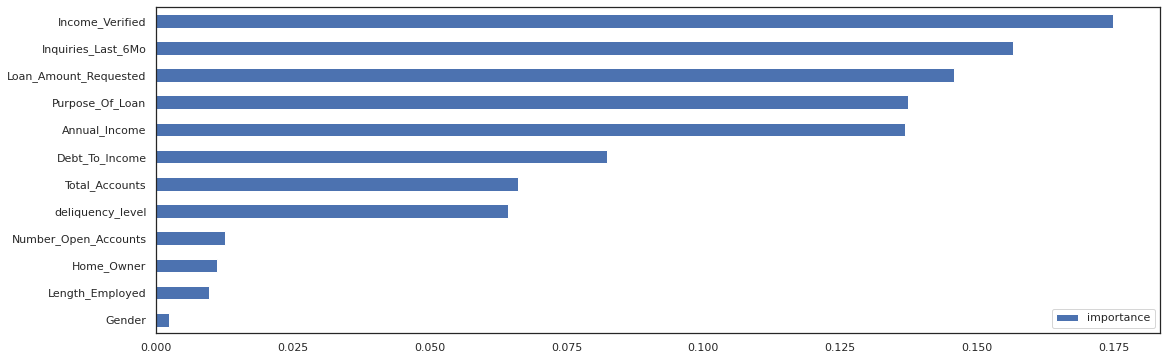

In [ ]:
pd.DataFrame({'importance' : decision_classifier.feature_importances_}, index=x.columns).sort_values(by='importance').plot(kind='barh')

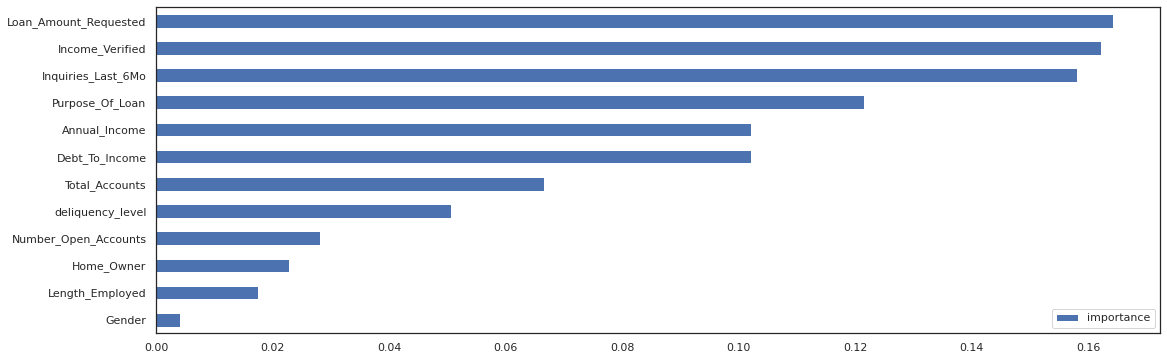

In [ ]:
pd.DataFrame({'importance' : random_forest_classifier.feature_importances_}, index=x.columns).sort_values(by='importance').plot(kind='barh')

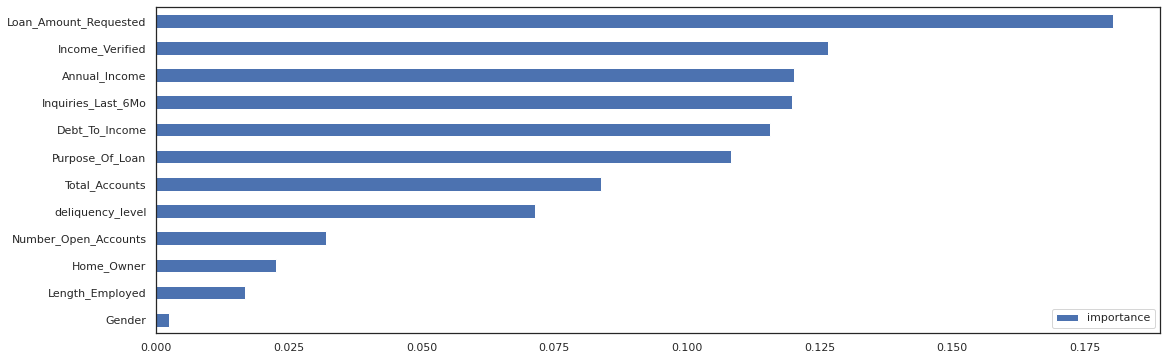

In [ ]:
pd.DataFrame({'importance' : gbm_classifier.feature_importances_}, index=x.columns).sort_values(by='importance').plot(kind='barh')

> <font color='#00e6de'></font>
<font color='#fa005c'></font>
<font color='#00e6de'>
From all the feature importances: <font color='#fa005c'> Number_Open_Accounts ,Home_Owner ,Length_Employed and Gender </font> are the least important with less than 5% importance in the entire dataset they explain <font color='#fa005c'> 4.7543, 8.2875, 6.5168 </font> respectively
</font>


### <font color='#00e6de'>Models 1</font>

In [45]:
loan_model = loans[['Loan_Amount_Requested','Debt_To_Income','Annual_Income','Income_Verified','Inquiries_Last_6Mo','Purpose_Of_Loan','Total_Accounts','deliquency_level','Interest_Rate']]
loan_model.head()

,Loan_Amount_Requested,Debt_To_Income,Annual_Income,Income_Verified,Inquiries_Last_6Mo,Purpose_Of_Loan,Total_Accounts,deliquency_level,Interest_Rate
0,7000,18.37,68000.000000,not verified,0,car,14,Low risk,1
1,30000,14.93,76646.058884,VERIFIED - income,0,debt_consolidation,24,High risk,3
2,24725,15.88,75566.400000,VERIFIED - income source,0,debt_consolidation,16,Low risk,3
3,16000,14.34,56160.000000,VERIFIED - income source,3,debt_consolidation,22,Low risk,3
4,17000,22.17,96000.000000,VERIFIED - income source,1,debt_consolidation,30,Low risk,1


In [46]:
from sklearn.preprocessing import LabelEncoder
loan_model['Interest_Rate'] = loan_model['Interest_Rate'].astype('category')
le = LabelEncoder()
for name in ('Income_Verified','Purpose_Of_Loan','deliquency_level'):
  labeled = le.fit_transform(loan_model[name])
  loan_model[name] = labeled
  #label encoding above ^
  loan_model[name] = loan_model[name].astype('category')
  # Changing to categorical
  print(loans[name].value_counts())
  print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
  print(loan_model[name].value_counts())
  print('********************************************************')

VERIFIED - income           59420
VERIFIED - income source    53013
not verified                51871
Name: Income_Verified, dtype: int64
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
0    59420
1    53013
2    51871
Name: Income_Verified, dtype: int64
********************************************************
debt_consolidation    97101
credit_card           36684
home_improvement       9268
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation                834
wedding                 828
house                   773
renewable_energy        122
educational             121
Name: Purpose_Of_Loan, dtype: int64
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
2     97101
1     36684
4      9268
9      8346
6      3435
11     2392
0      1885
7      1541
8       974
12      834
13      828
5       773
10      122
3       121
Name: Purpose_Of_Loan, dtype: int64
************************

In [47]:
x=loan_model.drop(['Interest_Rate',],axis=1)
y=loan_model['Interest_Rate']
x_train,x_test,y_train,y_test=train_test_split(x,y)

In [ ]:
#  Creating default models
decision_classifier = DecisionTreeClassifier()
random_forest_classifier = RandomForestClassifier()
gbm_classifier = GradientBoostingClassifier()
knn_classifier = KNeighborsClassifier()

# training our models
decision_classifier.fit(x_train, y_train)
random_forest_classifier.fit(x_train, y_train)
gbm_classifier.fit(x_train, y_train)

# making predictions using the models
decision_y_prediction = decision_classifier.predict(x_test) 
random_forest_y_pred = random_forest_classifier.predict(x_test)
gbm_y_pred = gbm_classifier.predict(x_test)

# evaluating the models
print('Decision Tree')
print(metrics.accuracy_score(decision_y_prediction, y_test))
print(metrics.confusion_matrix(decision_y_prediction, y_test))
print(metrics.classification_report(decision_y_prediction, y_test))


print('Random Forest')
print(metrics.accuracy_score(random_forest_y_pred, y_test))
print(metrics.confusion_matrix(random_forest_y_pred, y_test))
print(metrics.classification_report(random_forest_y_pred, y_test))

print('Gradient Boosting')
print(metrics.accuracy_score(gbm_y_pred, y_test))
print(metrics.confusion_matrix(gbm_y_pred, y_test))
print(metrics.classification_report(gbm_y_pred, y_test))


Decision Tree
0.42847404810594997
[[2748 3830 2162]
 [3706 7933 5884]
 [2057 5837 6919]]
              precision    recall  f1-score   support

           1       0.32      0.31      0.32      8740
           2       0.45      0.45      0.45     17523
           3       0.46      0.47      0.46     14813

    accuracy                           0.43     41076
   macro avg       0.41      0.41      0.41     41076
weighted avg       0.43      0.43      0.43     41076

Random Forest
0.4990018502288441
[[2384 2237  789]
 [4678 9988 6051]
 [1449 5375 8125]]
              precision    recall  f1-score   support

           1       0.28      0.44      0.34      5410
           2       0.57      0.48      0.52     20717
           3       0.54      0.54      0.54     14949

    accuracy                           0.50     41076
   macro avg       0.46      0.49      0.47     41076
weighted avg       0.52      0.50      0.51     41076

Gradient Boosting
0.532646801051709
[[ 1716  1166   296]
 [ 5

###<font color=”green”>Hyparameter Tuning</font>

**Gaussian Naive Bayes Classifier**

In [36]:
# Splitting the data into a training set and a test set (using a 80-20 split)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=6) 

In [37]:
# Feature Scaling 

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [38]:
# Training the model

clf = GaussianNB()  
model = clf.fit(x_train, y_train) 

In [39]:
# Making predictions

y_pred1 = model.predict(x_test)

# Comparing a sample of the prediction

comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred1})
print(comparison_frame.sample(n=5))
print(comparison_frame.describe())

      Actual  Predicted
63829      2          2
58033      2          2
8835       2          2
96554      3          2
38567      2          2
          Predicted
count  32861.000000
mean       2.255926
std        0.534667
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000


In [40]:
# Evaluating the model

print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

[[  853  4724  1209]
 [  592 10270  3395]
 [  123  6321  5374]]
              precision    recall  f1-score   support

           1       0.54      0.13      0.20      6786
           2       0.48      0.72      0.58     14257
           3       0.54      0.45      0.49     11818

    accuracy                           0.50     32861
   macro avg       0.52      0.43      0.42     32861
weighted avg       0.52      0.50      0.47     32861



The model has an accuracy score of 50%. The correct number of predictions are 10427 true positives and 5339 true negatives while the number of incorrect predictions are 3366 false positives and 6378 false negatives.

**60-40 Data Split**

In [41]:
# Splitting the data into a training set and a test set (using a 60-40 split)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=8) 

# Feature Scaling 

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Training the model
 
model = clf.fit(x_train, y_train) 

# Making predictions

y_pred2 = model.predict(x_test)

# Comparing a sample of the prediction

comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})
print(comparison_frame.sample(n=5))
print(comparison_frame.describe())

# Evaluating the model

print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

       Actual  Predicted
22464       2          2
135632      3          2
64201       3          2
97403       2          3
32512       2          2
          Predicted
count  65722.000000
mean       2.265725
std        0.579932
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000
[[ 2348  8563  2555]
 [ 1842 18815  7584]
 [  450 11600 11965]]
              precision    recall  f1-score   support

           1       0.51      0.17      0.26     13466
           2       0.48      0.67      0.56     28241
           3       0.54      0.50      0.52     24015

    accuracy                           0.50     65722
   macro avg       0.51      0.45      0.45     65722
weighted avg       0.51      0.50      0.48     65722



**Feature Reduction Using LDA**

In [55]:
# Defining the training and tests sets with an 60 - 40 split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

# Feature Scaling 

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Peforming LDA

lda = LDA(n_components=8)
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

# Checking the most important features
feature_importance = pd.DataFrame(index = x.columns.values, data = lda.coef_[0].T).sort_values(0, ascending= False)
feature_importance

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning:

n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(12, 3 - 1) = 2 components.

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning:

In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).



,0
Income_Verified,0.261214
Total_Accounts,0.239928
Annual_Income,0.164510
deliquency_level,0.084217
Gender,0.003968
Number_Open_Accounts,-0.021292
Length_Employed,-0.065674
Home_Owner,-0.144173
Purpose_Of_Loan,-0.175725
Loan_Amount_Requested,-0.201470


In [56]:
# Training the model
 
model = clf.fit(x_train, y_train) 

# Making predictions

y_pred_lda = model.predict(x_test)

# Comparing a sample of the prediction

comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lda})
print(comparison_frame.sample(n=5))
print(comparison_frame.describe())

# Evaluating the model

print(confusion_matrix(y_test, y_pred_lda))
print(classification_report(y_test, y_pred_lda))

      Actual  Predicted
41640      3          2
67573      1          2
19101      1          2
10448      3          2
80083      2          2
          Predicted
count  65722.000000
mean       2.281945
std        0.530639
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000
[[ 1320 10133  1999]
 [ 1022 20201  7113]
 [  258 11658 12018]]
              precision    recall  f1-score   support

           1       0.51      0.10      0.16     13452
           2       0.48      0.71      0.57     28336
           3       0.57      0.50      0.53     23934

    accuracy                           0.51     65722
   macro avg       0.52      0.44      0.42     65722
weighted avg       0.52      0.51      0.48     65722



With only 5 features, the model's performance has improved slightly. The accuracy score has increased to 51% and the precision and recall of the model has also improved.

# **Upsampling**

Since we have an imbalanced dataset, we can perform upsampling technique to further improve the performance of the model

In [93]:
# defining the two loan categories

true_loans = loans[loans['']==1]
non_loans = loans[loans['loans']==0]


# oversampling the minority category
from sklearn.utils import resample
over_loans = resample(true_loans, replace=True, n_samples=non_loans.shape[0])
oversampled = pd.concat([over_loans, non_loans])

KeyError: ignored

In [95]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [98]:
x_train,x_test,y_train,y_test=train_test_split(x,y)

ros = RandomOverSampler(random_state=0)
ros.fit(x, y)
# x_over_sampled, y_over_sampled = ros.fit_sample(x, y)

rus = RandomUnderSampler(random_state=0)
rus.fit(x, y)
# Creates higher accuracy cause its memorised
# x_under_sampled, y_under_sampled = rus.fit_sample(x, y)
# x_train, y_train = ros.fit_sample(x, y)


x_train, y_train = ros.fit_sample(x_train,y_train)




/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [99]:
np.bincount(y_train)

array([    0, 52814, 52814, 52814])

Rerunning after upsampling

In [100]:
# Splitting the data into a training set and a test set (using a 60-40 split)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=8) 

# Feature Scaling 

scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Training the model
 
model = clf.fit(x_train, y_train) 

# Making predictions

y_pred2 = model.predict(x_test)

# Comparing a sample of the prediction

comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})
print(comparison_frame.sample(n=5))
print(comparison_frame.describe())

# Evaluating the model

print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

       Actual  Predicted
59090       1          2
148489      1          3
142575      2          2
38657       2          2
77190       2          3
          Predicted
count  65722.000000
mean       2.265725
std        0.579932
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        3.000000
[[ 2348  8563  2555]
 [ 1842 18815  7584]
 [  450 11600 11965]]
              precision    recall  f1-score   support

           1       0.51      0.17      0.26     13466
           2       0.48      0.67      0.56     28241
           3       0.54      0.50      0.52     24015

    accuracy                           0.50     65722
   macro avg       0.51      0.45      0.45     65722
weighted avg       0.51      0.50      0.48     65722



**Hyperparameter Tuning**

In [ ]:
# Splitting our dataset into its attributes and labels
X = loans.drop(['Interest_Rates','Loan_Id'], axis=1).values
y = loans['spam'].values

In [105]:
clf4 = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GridSearchCV(estimator=clf4, 
                 param_grid=params_NB, 
                 cv=cv_method,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
clf.fit(x_train, y_train)

clf.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  1.1min finished


{'var_smoothing': 0.01519911082952933}

In [107]:
# Predicting our test predictors
y_pred = clf.predict(x_test)

In [108]:
##Evaluating the algorithm
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 2288  8646  2532]
 [ 1789 18923  7529]
 [  438 11680 11897]]
              precision    recall  f1-score   support

           1       0.51      0.17      0.25     13466
           2       0.48      0.67      0.56     28241
           3       0.54      0.50      0.52     24015

    accuracy                           0.50     65722
   macro avg       0.51      0.45      0.44     65722
weighted avg       0.51      0.50      0.48     65722

